### Load required libraries

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [55]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [56]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [57]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [58]:
df.isnull().values.any()

False

In [59]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [60]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [61]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [62]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [17]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

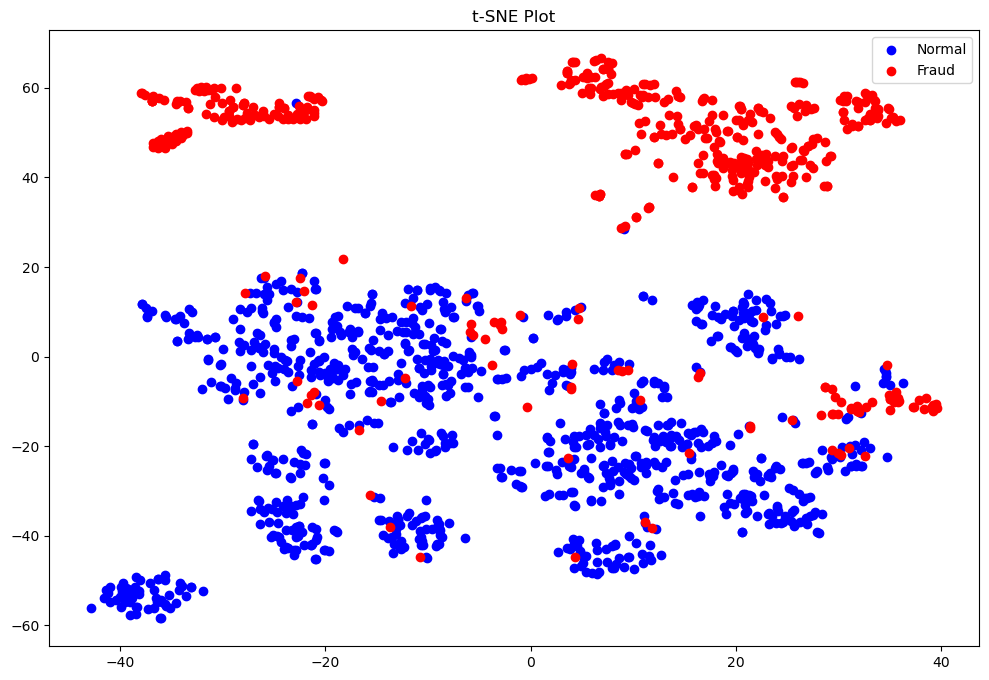

In [18]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

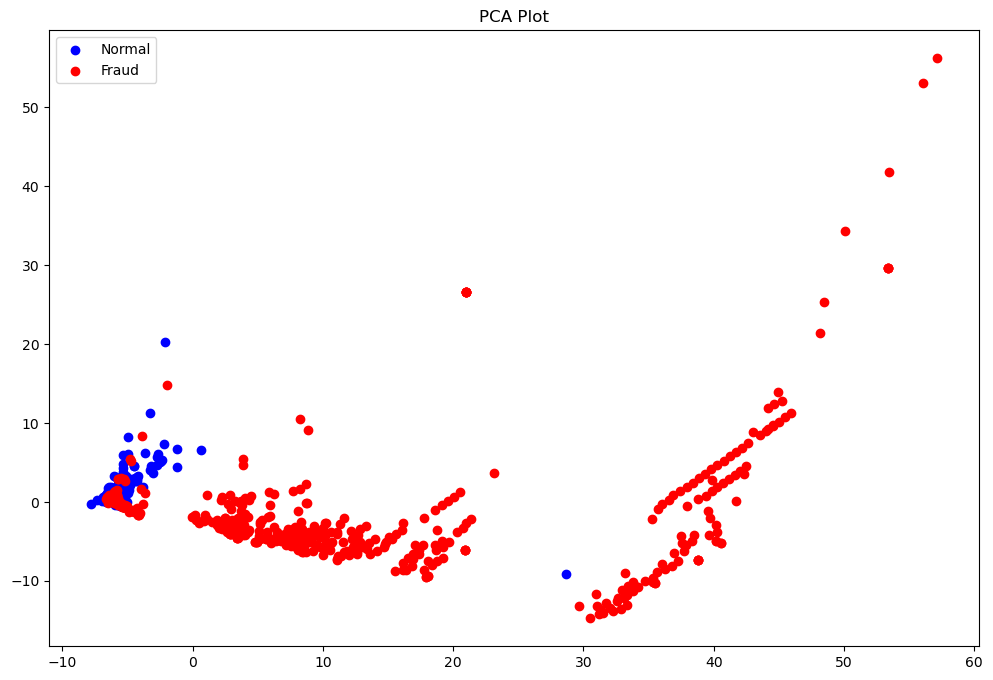

In [21]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### AutoEncoder Model

In [68]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
encoder = Dense(4, activation="relu")(encoder)

encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation="relu")(encoder)
decoder = Dense(7, activation="relu")(decoder)
decoder = Dense(14, activation='relu')(decoder)
decoder = Dense(input_dim)(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_86 (Dense)            (None, 14)                406       
                                                                 
 dense_87 (Dense)            (None, 7)                 105       
                                                                 
 dense_88 (Dense)            (None, 4)                 32        
                                                                 
 dense_89 (Dense)            (None, 2)                 10        
                                                                 
 dense_90 (Dense)            (None, 4)                 12        
                                                                 
 dense_91 (Dense)            (None, 7)                 35 

In [69]:
epochs = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudAE.pth", verbose=0, save_best_only=True)

### Training

In [70]:
history = autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.8198 - accuracy: 0.3593INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.8194 - accuracy: 0.3595 - val_loss: 0.6905 - val_accuracy: 0.4218
Epoch 2/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.4326INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6857 - accuracy: 0.4326 - val_loss: 0.6426 - val_accuracy: 0.4460
Epoch 3/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.4529INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.6611 - accuracy: 0.4529 - val_loss: 0.6302 - val_accuracy: 0.4615
Epoch 4/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.4641INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.6482 - accuracy: 0.4642 - val_loss: 0.6168 - val_accuracy: 0.4709
Epoch 5/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.6357 - accuracy: 0.4677INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.6357 - accuracy: 0.4678 - val_loss: 0.6091 - val_accuracy: 0.4725
Epoch 6/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.6261 - accuracy: 0.4670INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6261 - accuracy: 0.4669 - val_loss: 0.5955 - val_accuracy: 0.4705
Epoch 7/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.6171 - accuracy: 0.4663INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.6170 - accuracy: 0.4663 - val_loss: 0.5884 - val_accuracy: 0.4721
Epoch 8/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.4686INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6102 - accuracy: 0.4686 - val_loss: 0.5823 - val_accuracy: 0.4752
Epoch 9/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.6026 - accuracy: 0.4706INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.6025 - accuracy: 0.4706 - val_loss: 0.5755 - val_accuracy: 0.4780
Epoch 10/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5919 - accuracy: 0.4820INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5917 - accuracy: 0.4820 - val_loss: 0.5630 - val_accuracy: 0.4931
Epoch 11/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.4970INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5798 - accuracy: 0.4971 - val_loss: 0.5567 - val_accuracy: 0.5035
Epoch 12/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5733 - accuracy: 0.5039INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5733 - accuracy: 0.5040 - val_loss: 0.5551 - val_accuracy: 0.5084
Epoch 13/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5686 - accuracy: 0.5106INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.5685 - accuracy: 0.5106 - val_loss: 0.5531 - val_accuracy: 0.5083
Epoch 14/100
5574/5598 [============================>.] - ETA: 0s - loss: 0.5642 - accuracy: 0.5187INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5640 - accuracy: 0.5186 - val_loss: 0.5403 - val_accuracy: 0.5326
Epoch 15/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5604 - accuracy: 0.5224INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5607 - accuracy: 0.5224 - val_loss: 0.5401 - val_accuracy: 0.5257
Epoch 16/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5635 - accuracy: 0.5232 - val_loss: 0.5430 - val_accuracy: 0.5346
Epoch 17/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5572 - accuracy: 0.5259 - val_loss: 0.5409 - val_accuracy: 0.5177
Epoch 18/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5565 - accuracy: 0.5244INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.5565 - accuracy: 0.5243 - val_loss: 0.5349 - val_accuracy: 0.5297
Epoch 19/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.5572 - accuracy: 0.5241 - val_loss: 0.5792 - val_accuracy: 0.5114
Epoch 20/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5563 - accuracy: 0.5253 - val_loss: 0.5356 - val_accuracy: 0.5273
Epoch 21/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.5260INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.5506 - accuracy: 0.5260 - val_loss: 0.5341 - val_accuracy: 0.5279
Epoch 22/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.5510 - accuracy: 0.5261INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.5509 - accuracy: 0.5262 - val_loss: 0.5327 - val_accuracy: 0.5291
Epoch 23/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5498 - accuracy: 0.5290 - val_loss: 0.5393 - val_accuracy: 0.5335
Epoch 24/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5446 - accuracy: 0.5297 - val_loss: 0.5328 - val_accuracy: 0.5310
Epoch 25/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5496 - accuracy: 0.5283 - val_loss: 0.5338 - val_accuracy: 0.5398
Epoch 26/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.5307INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.5398 - accuracy: 0.5307 - val_loss: 0.5310 - val_accuracy: 0.5299
Epoch 27/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5442 - accuracy: 0.5290INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.5442 - accuracy: 0.5290 - val_loss: 0.5268 - val_accuracy: 0.5407
Epoch 28/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5363 - accuracy: 0.5312 - val_loss: 0.5285 - val_accuracy: 0.5297
Epoch 29/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5349 - accuracy: 0.5325 - val_loss: 0.5268 - val_accuracy: 0.5322
Epoch 30/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5360 - accuracy: 0.5323 - val_loss: 0.5615 - val_accuracy: 0.5164
Epoch 31/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.5343INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5319 - accuracy: 0.5343 - val_loss: 0.5234 - val_accuracy: 0.5450
Epoch 32/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5369 - accuracy: 0.5339INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5369 - accuracy: 0.5338 - val_loss: 0.5217 - val_accuracy: 0.5455
Epoch 33/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5307 - accuracy: 0.5389 - val_loss: 0.5230 - val_accuracy: 0.5413
Epoch 34/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5292 - accuracy: 0.5386 - val_loss: 0.5244 - val_accuracy: 0.5478
Epoch 35/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.5404INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5277 - accuracy: 0.5404 - val_loss: 0.5207 - val_accuracy: 0.5466
Epoch 36/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.5407INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.5266 - accuracy: 0.5407 - val_loss: 0.5197 - val_accuracy: 0.5514
Epoch 37/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5266 - accuracy: 0.5402 - val_loss: 0.5250 - val_accuracy: 0.5424
Epoch 38/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5257 - accuracy: 0.5405INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.5256 - accuracy: 0.5405 - val_loss: 0.5176 - val_accuracy: 0.5457
Epoch 39/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.5246 - accuracy: 0.5421 - val_loss: 0.5210 - val_accuracy: 0.5470
Epoch 40/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5233 - accuracy: 0.5427 - val_loss: 0.5270 - val_accuracy: 0.5460
Epoch 41/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5262 - accuracy: 0.5422INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5262 - accuracy: 0.5423 - val_loss: 0.5172 - val_accuracy: 0.5509
Epoch 42/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.5225 - accuracy: 0.5415 - val_loss: 0.5183 - val_accuracy: 0.5475
Epoch 43/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.5438INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.5223 - accuracy: 0.5438 - val_loss: 0.5145 - val_accuracy: 0.5444
Epoch 44/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5223 - accuracy: 0.5426 - val_loss: 0.5241 - val_accuracy: 0.5470
Epoch 45/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5207 - accuracy: 0.5433 - val_loss: 0.5360 - val_accuracy: 0.5456
Epoch 46/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5201 - accuracy: 0.5412 - val_loss: 0.5788 - val_accuracy: 0.5248
Epoch 47/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.5419INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.5217 - accuracy: 0.5419 - val_loss: 0.5124 - val_accuracy: 0.5457
Epoch 48/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5196 - accuracy: 0.5420 - val_loss: 0.5200 - val_accuracy: 0.5578
Epoch 49/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.5418INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.5228 - accuracy: 0.5419 - val_loss: 0.5120 - val_accuracy: 0.5478
Epoch 50/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5169 - accuracy: 0.5400INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5170 - accuracy: 0.5400 - val_loss: 0.5111 - val_accuracy: 0.5450
Epoch 51/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5188 - accuracy: 0.5389 - val_loss: 0.5185 - val_accuracy: 0.5426
Epoch 52/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.5177 - accuracy: 0.5401 - val_loss: 0.5114 - val_accuracy: 0.5489
Epoch 53/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5187 - accuracy: 0.5391 - val_loss: 0.5181 - val_accuracy: 0.5473
Epoch 54/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5173 - accuracy: 0.5396 - val_loss: 0.5148 - val_accuracy: 0.5485
Epoch 55/100
5577/5598 [============================>.] - ETA: 0s - loss: 0.5188 - accuracy: 0.5382INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5188 - accuracy: 0.5381 - val_loss: 0.5101 - val_accuracy: 0.5479
Epoch 56/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5182 - accuracy: 0.5389 - val_loss: 0.5115 - val_accuracy: 0.5465
Epoch 57/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5191 - accuracy: 0.5391 - val_loss: 0.5162 - val_accuracy: 0.5446
Epoch 58/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5192 - accuracy: 0.5396 - val_loss: 0.5177 - val_accuracy: 0.5392
Epoch 59/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5176 - accuracy: 0.5387 - val_loss: 0.5172 - val_accuracy: 0.5442
Epoch 60/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5177 - accuracy: 0.5393 - val_loss: 0.5112 - val_accuracy: 0.5454
Epoch 61/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5168 - accuracy: 0.5387INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5167 - accuracy: 0.5386 - val_loss: 0.5087 - val_accuracy: 0.5488
Epoch 62/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5158 - accuracy: 0.5384 - val_loss: 0.5102 - val_accuracy: 0.5411
Epoch 63/100
5579/5598 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.5376INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.5152 - accuracy: 0.5377 - val_loss: 0.5070 - val_accuracy: 0.5447
Epoch 64/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5133 - accuracy: 0.5388 - val_loss: 0.5103 - val_accuracy: 0.5468
Epoch 65/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5129 - accuracy: 0.5376 - val_loss: 0.5099 - val_accuracy: 0.5434
Epoch 66/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.5135 - accuracy: 0.5382 - val_loss: 0.5090 - val_accuracy: 0.5475
Epoch 67/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5138 - accuracy: 0.5375 - val_loss: 0.5171 - val_accuracy: 0.5421
Epoch 68/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5144 - accuracy: 0.5370 - val_loss: 0.5098 - val_accuracy: 0.5487
Epoch 69/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.5367INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5132 - accuracy: 0.5367 - val_loss: 0.5065 - val_accuracy: 0.5436
Epoch 70/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5123 - accuracy: 0.5372 - val_loss: 0.5099 - val_accuracy: 0.5435
Epoch 71/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5137 - accuracy: 0.5363 - val_loss: 0.5070 - val_accuracy: 0.5419
Epoch 72/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.5352INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5130 - accuracy: 0.5352 - val_loss: 0.5053 - val_accuracy: 0.5444
Epoch 73/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5121 - accuracy: 0.5377INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5119 - accuracy: 0.5377 - val_loss: 0.5044 - val_accuracy: 0.5446
Epoch 74/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.5384INFO:tensorflow:Assets written to: fraudAE.pth\assets


INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5118 - accuracy: 0.5384 - val_loss: 0.5039 - val_accuracy: 0.5503
Epoch 75/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5114 - accuracy: 0.5385 - val_loss: 0.5099 - val_accuracy: 0.5475
Epoch 76/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5103 - accuracy: 0.5383 - val_loss: 0.5067 - val_accuracy: 0.5418
Epoch 77/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5148 - accuracy: 0.5381 - val_loss: 0.5292 - val_accuracy: 0.5370
Epoch 78/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5111 - accuracy: 0.5371 - val_loss: 0.5077 - val_accuracy: 0.5485
Epoch 79/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5108 - accuracy: 0.5383 - val_loss: 0.5042 - val_accuracy: 0.5477
Epoch 80/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5111 - accuracy: 0.5386 - val_loss: 0.5044 - val_a

INFO:tensorflow:Assets written to: fraudAE.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.5102 - accuracy: 0.5375 - val_loss: 0.5022 - val_accuracy: 0.5436
Epoch 87/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5084 - accuracy: 0.5380 - val_loss: 0.5045 - val_accuracy: 0.5477
Epoch 88/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5099 - accuracy: 0.5381 - val_loss: 0.5075 - val_accuracy: 0.5324
Epoch 89/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5093 - accuracy: 0.5383 - val_loss: 0.5028 - val_accuracy: 0.5450
Epoch 90/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5095 - accuracy: 0.5392 - val_loss: 0.5048 - val_accuracy: 0.5471
Epoch 91/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5088 - accuracy: 0.5391 - val_loss: 0.5353 - val_accuracy: 0.5399
Epoch 92/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5087 - accuracy: 0.5377 - val_loss: 0.5099 - val_a

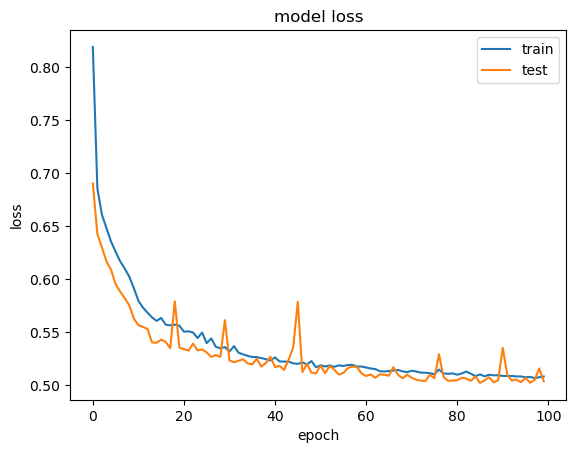

In [71]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [72]:
ae = load_model('fraudAE.pth')

In [73]:
predictions = ae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 5s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.538582,0.00165
std,1.833445,0.04059
min,0.064341,0.00000
25%,0.215757,0.00000
50%,0.328778,0.00000
75%,0.569955,0.00000
max,121.063864,1.00000


In [74]:
threshold = 2.9

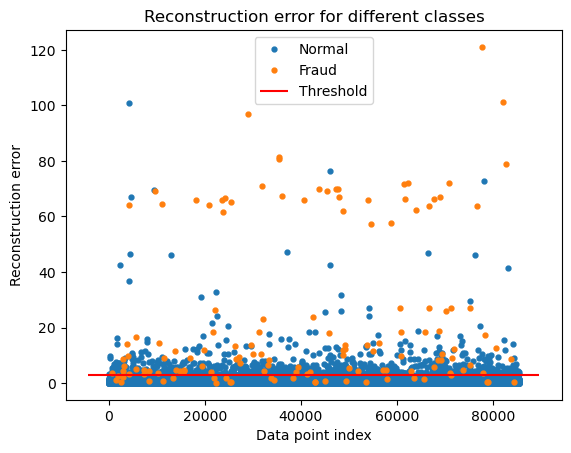

In [75]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

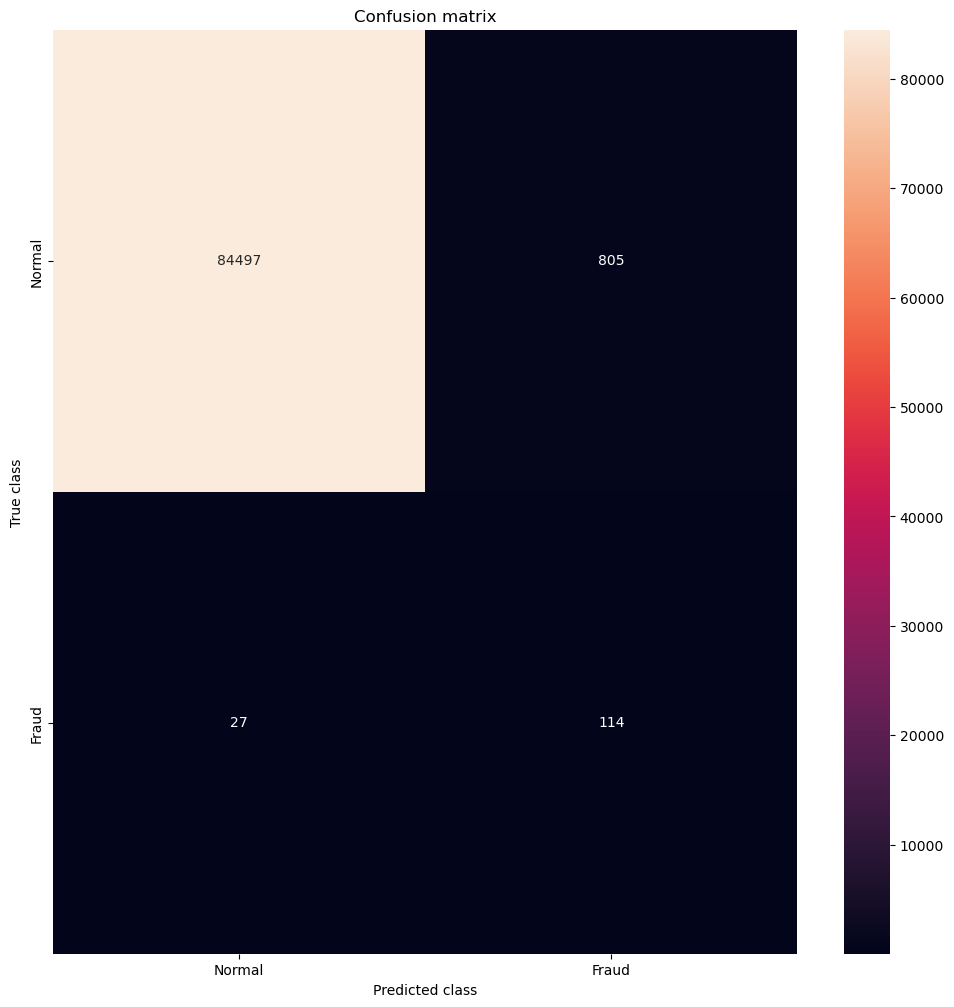

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [78]:
inp_layer = ae.input
out_layer = ae.layers[4].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [79]:
encoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_86 (Dense)            (None, 14)                406       
                                                                 
 dense_87 (Dense)            (None, 7)                 105       
                                                                 
 dense_88 (Dense)            (None, 4)                 32        
                                                                 
 dense_89 (Dense)            (None, 2)                 10        
                                                                 
Total params: 553 (2.16 KB)
Trainable params: 553 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2671/2671 [==============================] - 4s 2ms/step


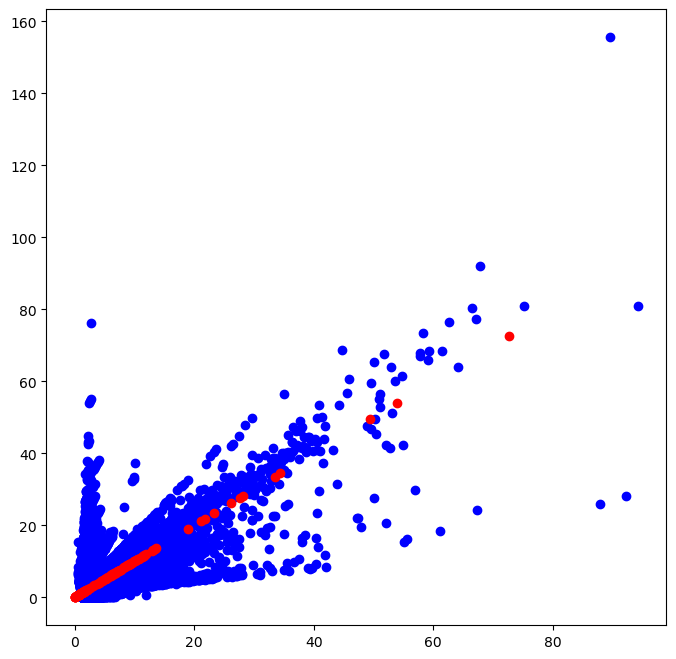

In [95]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[2]==0][0],encoded_df[encoded_df[2]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[2]==1][1],encoded_df[encoded_df[2]==1][1], color='red', label='Fraud');